# Introduction

This notebook allows you to run a simplified version of the ANTARESS workflow, for the following purpose:
- performing a Rossiter-McLaughlin Revolutions (RMR) analysis for a transiting planet

To use this notebook you need to have extracted intrinsic CCFs from a transit time-series using the [processing notebook](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_processing.ipynb). The default version of this notebook is set up to process the mock dataset generated with ANTARESS [set-up notebook](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_setup_Arda.ipynb) and [mock notebook](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_mock.ipynb). To try it out, copy the directory `Arda/` from `Notebooks/Mock_system/` into the directory of your choice (named, for example, `Working_dir/`) and set `working_path` to this directory location. Otherwise adjust the settings to retrieve your own processed dataset, setting `working_path`, `star_name`, and `pl_name` to the same values that you used to initialize your [observed](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_setup.ipynb) or [mock](https://gitlab.unige.ch/spice_dune/antaress/-/blob/main/Notebooks/ANTARESS_nbook_setup_Arda.ipynb) system.

To exploit the workflow to its full capabilities, run its executable with the [configuration files](https://obswww.unige.ch/~bourriev/antaress/doc/html/installation.html).

In [1]:
import ANTARESS_nbook_bground
input_nbook = {
    'working_path' : '/Users/bourrier/Travaux/ANTARESS/Working_dir/',
    'star_name' : 'Arda',
    'pl_name' : 'Valinor'
}
input_nbook=ANTARESS_nbook_bground.load_nbook(input_nbook, 'RMR')

The RMR approach consists in three successive steps:

- fitting the intrinsic stellar line in each exposure
- fitting the derived series of line properties
- performing a joint fit to all intrinsic stellar lines

Fits can be performed using a MCMC (`fit_mode = "MCMC"`) rather than the default least-square minimization (`fit_mode = "chi2"`). When running a MCMC you may adjust the default number of walkers, their steps, and the burn-in phase by uncommenting the `mcmc_set` dictionary. Check the MCMC chains to adjust these numbers, depending on your dataset quality and the number of free parameters. Since running a MCMC may take some time, you can set `calc_fit` to `False` once the MCMC is done and you only want to manipulate the [plots](#Plot_display).

Default priors for the fitted parameters can be overwritten by uncommenting the `priors` field, and defining lower and upper boundaries for the uniform prior ranges. 

After setting up a step, [run ANTARESS](#Launch_ANTARESS) and use the fit results and associated plots to prepare the next step. The run log will display the median, 1-$\sigma$ errors, and associated confidence intervals for each fitted parameter. 

# Step 1 : individual profiles fits

**Analysis**

Run this cell to perform a Gaussian fit to each intrinsic CCF, and derive the rv, FWHM, and contrast of the average stellar line from regions occulted along the transit chord. Step 1 and 2 are used to identify which exposures should be included in the joint profile fit (Step 3), by assessing the quality of individual intrinsic CCFs and the series of derived line properties. 

Intrinsic CCFs are usually measured with low S/N, in which case it is advised to run the fits using a MCMC. This step settings can be adjusted based on the plots, as well as the MCMC chains and corner plots in `/Working_dir/Star/Planet_Saved_data/Introrig_prop/instrument_night_mcmc/iexp*/`.

Although the Gaussian model used here includes instrumental convolution, it is an approximation compared to using ANTARESS numerical stellar grid (as in done in the full workflow, and in Step 3 for the joint profile fit). Here we do not account in particular for the blurring induced by the planet motion, which is significant for long exposure times and fast-rotators. Use the configuration file if you want to fit more finely individual intrinsic profiles. 

In [2]:
## Uncomment to use the MCMC
input_nbook['par']['fit_mode'] = 'mcmc'

## Uncomment to adjust the MCMC chains (default nwalkers = 50, nsteps = 1000, nburn = 200)
input_nbook['par']['mcmc_set']={'nwalkers':20,'nsteps':800,'nburn':200} 

## Uncomment to set your own priors
input_nbook['par']['priors']={        
    'rv':   {'low':-4.0,'high':4.0},    
    'FWHM': {'low': 0.5,'high':4.5},
    'ctrst':{'low': 0.4,'high':0.9}}

# Set to True to run the fit, and to False to retrieve its results
input_nbook['par']['calc_fit'] = True  

ANTARESS_nbook_bground.ana_prof(input_nbook,'Intr')

**Plotting**

Run this cell to plot the intrinsic CCF series with their best fits.

Adjust `x_range` to the rv range of the profiles. Use `y_range` to adjust the flux range of the CCFs (vertical axis), or set to `None` for automatic determination.

In [3]:
input_nbook['par']['x_range'] = [-31.,31.]
input_nbook['par']['y_range'] = [0.4,1.1]
ANTARESS_nbook_bground.plot_prof(input_nbook,'Intr_prof')

# Step 2 : properties fit

**Analysis**

Run this cell to fit the series of rv, contrast, and FWHM derived in Step 1. Step 2 is used to determine the best models describing variations of these properties along the transit chord, which will then be used in the joint profile fit (Step 3). Guess values for the joint fit can further be informed by the results of Step 2.

You can fit all in-transit exposures by setting `idx_in_fit` to `all`. However the occulted stellar lines and their derived properties may be so noisy in some exposures, especially at the stellar limbs, that they do not bring any constraints. It also happens that the planet only occults the star for a small fraction of the ingress/egress exposures, as in the example mock dataset, so that the model planet does not transit. In that case, you can change `idx_in_fit` to a list of the exposure indexes to fit (counted from 0 from the first in-transit exposure). If the star is too faint or the planet too small, all properties may be derived with a precision that is too low to analyze them here. In that case, skip Step 2 and apply directly the joint profile fit with the simplest models describing the line properties. 

Property models are controlled by parameters `x`, for which you must define a range [${\rm x}_{\rm low}$,${\rm x}_{\rm high}$] in the `mod_prop` dictionary. If you run a ${\chi}^{2}$ fit, it will be initialized with the mean of this range. If you run a MCMC fit, its walkers will be initialized over this range. If the data allows it you can increase the complexity of the models by uncommenting additional parameters, as described below.

- The intrinsic rv series traces the motion of the stellar surface along the transit chord, and thus depends on the sky-projected angle `lambda` (in degrees) between the stellar spin and orbital normal, and on the sky-projected stellar rotational velocity `veq` (in km/s). Here we assume solid-body rotation for the star, so that the stellar inclination is degenerate and fixed to 90$^{\circ}$. The rv model can be modulated by stellar differential rotation, in which case you can break this degeneracy and fit for `istar` (in degrees) and the coefficient `alpha` (0 corresponds to solid rotation, 1 to the poles not rotating). The rv model can further be modulated by convective blueshift, defined as a polynomial of the center-to-limb angle for which you can control the linear or quadratic coefficients `c1_CB` and `c2_CB` (in km/s).

- The intrinsic contrast and FWHM series trace the shape of the planet-occulted stellar lines along the transit chord. They are modelled as polynomials of the center-to-limb angle for which you can control the coefficients `x_i`, with `i`$\ge0$.

This step settings can be adjusted based on the plots, as well as the MCMC chains and corner plots in `/Working_dir/Star/Planet_Saved_data/Joined_fits/IntrProp/mcmc/x/`.



In [4]:
# Exposures to be fitted
input_nbook['par']['idx_in_fit'] = range(1,25)

## Uncomment to use the MCMC
input_nbook['par']['fit_mode'] = 'mcmc'

## Uncomment to adjust the MCMC chains (default nwalkers = 50, nsteps = 1000, nburn = 200)
input_nbook['par']['mcmc_set']={'nwalkers':20,'nsteps':1500,'nburn':500} 

# Surface RV: main parameters
input_nbook['par']['mod_prop']={ 
    'veq':   [0.,10.],
    'lambda':[-180.,180.]    
}

## Surface RV: convective blueshift
#input_nbook['par']['mod_prop']['c1_CB']=[-1.,1.] 
#input_nbook['par']['mod_prop']['c2_CB']=[-1.,1.]

## Surface RV: differential rotation
#input_nbook['par']['mod_prop']['alpha']=[0.,0.2] 
#input_nbook['par']['mod_prop']['istar']=[-90.,90.]

# Intrinsic line contrast and FWHM: polynomial coefficients
input_nbook['par']['mod_prop']['contrast_0']=[0.5,1.]   
#input_nbook['par']['mod_prop']['contrast_1']=[-1.,1.]   
input_nbook['par']['mod_prop']['FWHM_0']=[1.,6.]   
#input_nbook['par']['mod_prop']['FWHM_1']=[-5.,5.]

## Uncomment to set your own priors
input_nbook['par']['priors']={        
    'veq':       {'low':1.,   'high':5.},  
    'lambda':    {'low':-180.,'high':180.},  
    'contrast_0':{'low':0.5,  'high':1.},    
    'FWHM_0':    {'low':0.,   'high':8.}}

# Set to True to run the fit, and to False to retrieve its results
input_nbook['par']['calc_fit'] = True 

ANTARESS_nbook_bground.ana_jointprop(input_nbook,'Intr')

**Plotting**

Run this cell to plot the series of intrinsic properties and their best-fit models. 

Use `x_range` to adjust the phase range and `y_range` to adjust the property range (set to `None` for automatic determination).

In [5]:
input_nbook['par']['x_range'] = [-0.018,0.018]
input_nbook['par']['y_range'] = {
    'rv':      [-4.,4.],  
    'contrast':[0.4,0.9],  
    'FWHM':    [0.,6.]}
ANTARESS_nbook_bground.plot_prop(input_nbook,'Intr')

# Step 3 : joint profiles fit

**Analysis**

Run this cell to fit a joint model of the planet-occulted lines to all exposures that you request with `idx_in_fit`, based on your analysis from the Steps 1 and 2. Results from Step 2 can further be used to define, initialize, and constrain the parameters controlling the line properties models.

It is advised to run the fit through a MCMC, which you can set up after a preliminary run by checking the MCMC chains in `/Working_dir/Star/Planet_Saved_data/Joined_fits/IntrProf/mcmc/`. Best-fit values and associated uncertainties can be read in the log, or retrieved with additional information in the file `Outputs` file of the above directory.

This notebook assumes a simple Gaussian profile for the intrinsic lines, with default properties for ANTARESS stellar grid that may not be optimal for your dataset. Additional options are available through the workflow configuration file. 

In [6]:
# Exposures to be fitted
input_nbook['par']['idx_in_fit'] = range(1,25)

## Uncomment to use the MCMC
input_nbook['par']['fit_mode'] = 'mcmc'

# Uncomment to adjust the MCMC chains (default nwalkers = 3 x number of free parameters, nsteps = 5000, nburn = 1000)    
input_nbook['par']['mcmc_set']={'nwalkers':20,'nsteps':1500,'nburn':500} 

# Model parameters
input_nbook['par']['mod_prop']={ 
    'veq':       [0.,5.],
#    'cos_istar':[-1.,1.],    
    'lambda':    [0.,90.],
    'contrast_0':[0.2,0.8],    
    'FWHM_0':    [1.,4.]}   

## Uncomment to set your own priors
input_nbook['par']['priors']={        
    'veq':       {'low':0.,'high':10.},
#    'cos_istar':{'low':-1.,'high':1},
    'lambda':    {'low':-360.,'high':360.},  
    'contrast_0':{'low':0.,'high':1.},    
    'FWHM_0':    {'low':0.,'high':10.}}

# Set to True to run the fit, and to False to retrieve its results
input_nbook['par']['calc_fit'] = True 

ANTARESS_nbook_bground.ana_jointprof(input_nbook,'Intr')

**Plotting**

The next cells set up phase vs rv maps plots.
Use `x_range` to adjust the rv range of the maps and `v_range` to adjust their flux range (corresponding to the map color scale).

In [7]:
input_nbook['par']['x_range'] = [-31.,31.]

Run the cell below cell to plot a map of intrinsic CCFs.

In [8]:
input_nbook['par']['v_range'] = [0.4,1.1]
ANTARESS_nbook_bground.plot_map(input_nbook,'Intr_prof')

**Skip the next plotting cells if you have not yet performed the joint fit in Step 3**

Run the cell below to generate the model intrinsic CCFs that correspond to your best joint fit. This is required for the next two plots.

In [9]:
ANTARESS_nbook_bground.loc_prof_est(input_nbook)

Run the cell below to plot a map of your model intrinsic CCFs.

In [10]:
input_nbook['par']['v_range'] = [0.4,1.1]
ANTARESS_nbook_bground.plot_map(input_nbook,'Intr_prof_est')

Run the cell below to plot a map of residuals between your fitted and model intrinsic CCFs.

In [11]:
input_nbook['par']['v_range'] = [-1700,1700]
ANTARESS_nbook_bground.plot_map(input_nbook,'Intr_prof_res')

<a id='Launch_ANTARESS'></a>
# Running ANTARESS

Run this cell to run the ANTARESS workflow.

In [12]:
from antaress.ANTARESS_launch.ANTARESS_launcher import ANTARESS_launcher
ANTARESS_nbook_bground.call_sequence(input_nbook, 'RMR')
ANTARESS_launcher(working_path=input_nbook['working_path'], nbook_dic = input_nbook, exec_comm=False)

****************************************
Launching ANTARESS
****************************************

Multi-threading: 16 threads available
Running with artificial data
Covariances discounted
Study of: Valinor
Accounting for Keplerian motion from all planets
Automatic definition of T14[Valinor]=2.99 h
Default nsub_Dpl[Valinor]=124

-----------------------
Processing instrument : ESPRESSO
-----------------------
  Reading and initializing CCFs
   > Data resampled on a common spectral table
         Retrieving data
         Processing visit mockvis
           All exposures share a common spectral table
           50 exposures
  -----------------
  Processing visit: mockvis
  -----------------
   > 50 exposures
         26 in-transit
         24 out-of-transit (12 pre / 12 post)
   > Calculating properties of planet-occulted regions
         Calculating data
   > Analyzing disk-integrated stellar profiles
         Calculating data
         Systemic rv from time-series = 0.124448 +- 1.4095

<a id='Plot_display'></a>
# Plot display

In [13]:
from IPython.display import Image
from IPython.core.display import HTML 

Run the cells below to show saved plots.

**Intrinsic CCF series**

This plot shows the time-series of intrinsic CCFs (blue profiles) with their best-fit Gaussian models (dashed black profiles), from which are derived the properties showed in the next plots.

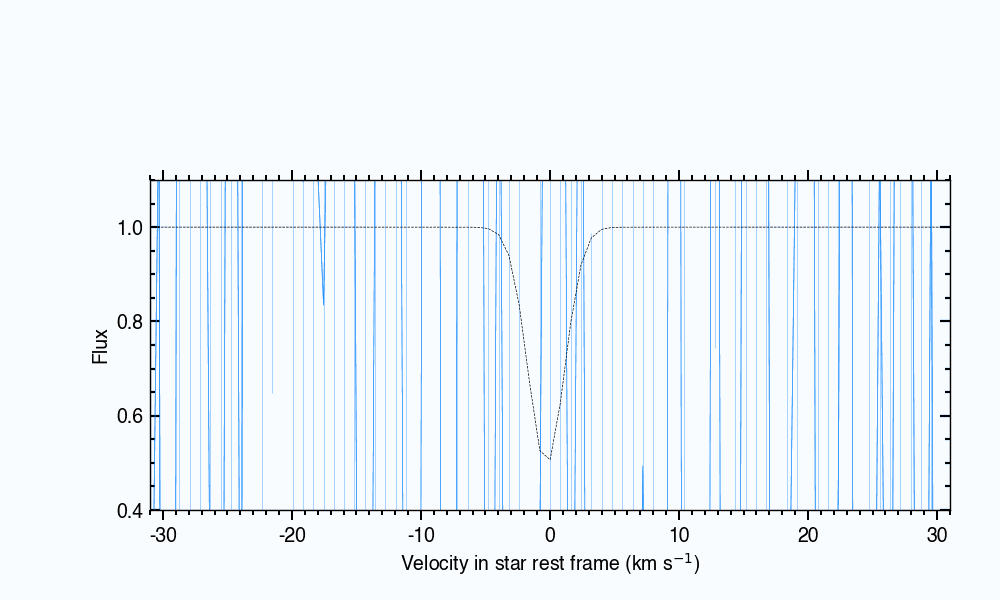

In [14]:
Image(filename = input_nbook['plot_path']+'Intr_data/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'_Indiv/Data/'+input_nbook['par']['prof_type']+'/phase.gif')

**Intrinsic line properties**

The three plots below show the time-series of rv, contrast, and FWHM derived from the fits to intrinsic CCFs, which directly trace the properties of the photosphere along the transit chord. Transit contacts are shown as dashed black lines.

The dashed orange lines show the best-fit models you derived for each property series (if run in Step 2). You can see how the decreasing intensity at the stellar limb, combined with its partial occultation by the planet, leads to intrinsic properties being derived at a lower precision. For smaller planets and fainter stars all exposures may yield a poor fit individually, making it hazardous to interpret the property time series. Fortunately, useful information can still be retrieved from these exposures by fitting the time series of intrinsic line profiles with a joint model through a joint fit to all CCF profiles. The dashed black lines show the properties associated with this global best fit (if run in Step 3).

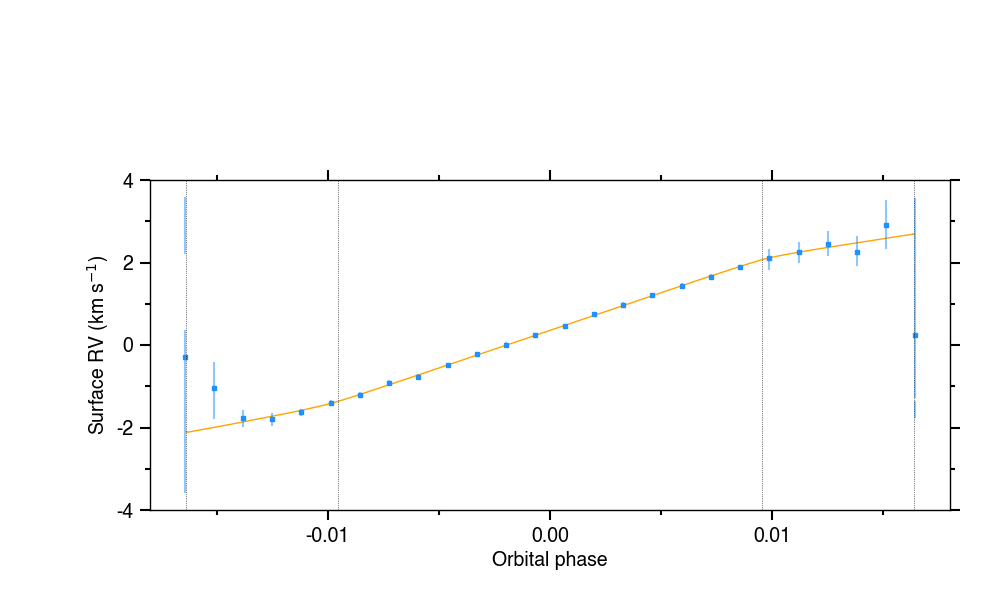

In [15]:
Image(filename = input_nbook['plot_path']+'Intr_prop/rv_phase.png')

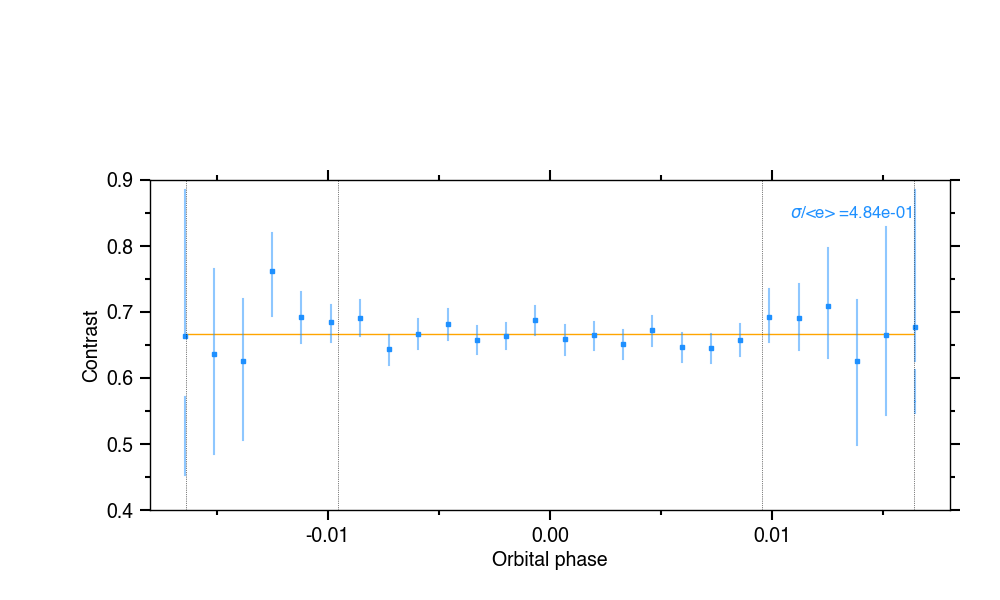

In [16]:
Image(filename = input_nbook['plot_path']+'Intr_prop/ctrst_phase.png')

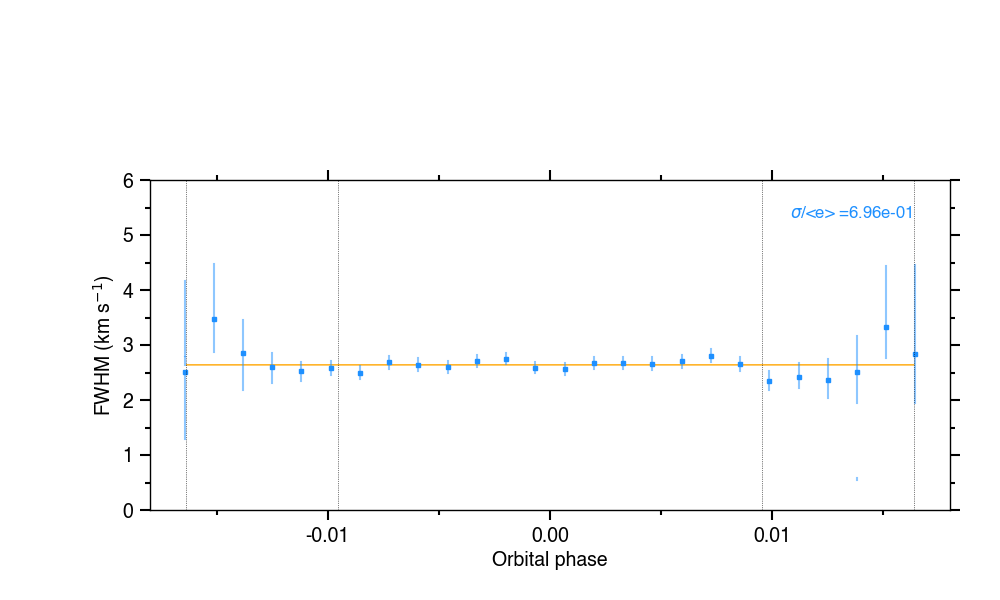

In [17]:
Image(filename = input_nbook['plot_path']+'Intr_prop/FWHM_phase.png')

**Intrinsic CCF maps**

The first plot shows the series of intrinsic CCFs as a function of rv in the star rest frame and orbital phase, colored with flux. The solid green line traces the centroid of the model stellar lines occulted by the planet, as derived from your best RM Revolutions fit to the full dataset (shown in the second plot). The third plot shows the residual values between the processed and model intrinsic CCFs.

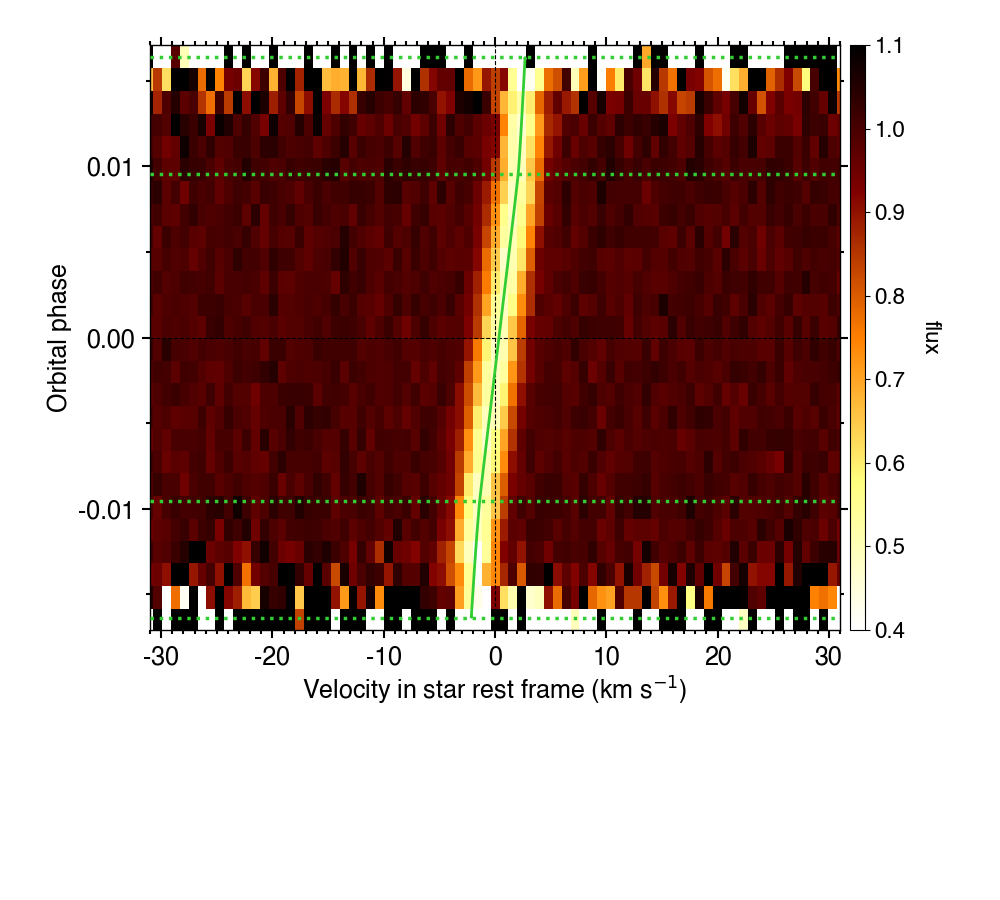

In [18]:
Image(filename = input_nbook['plot_path']+'Intr_data/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'_Map/Data/'+input_nbook['par']['prof_type']+'/iord0.png')

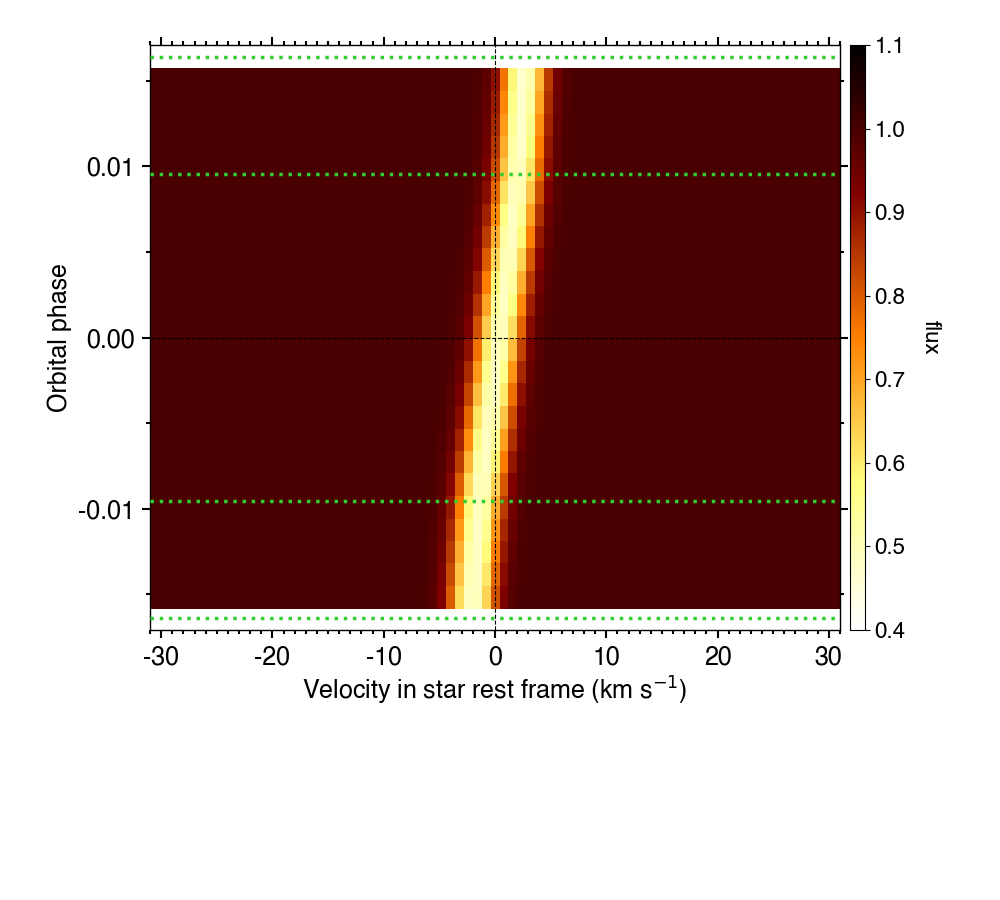

In [19]:
Image(filename = input_nbook['plot_path']+'Intr_data/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'_Map/Model/'+input_nbook['par']['prof_type']+'/iord0_glob_mod_rec.png')

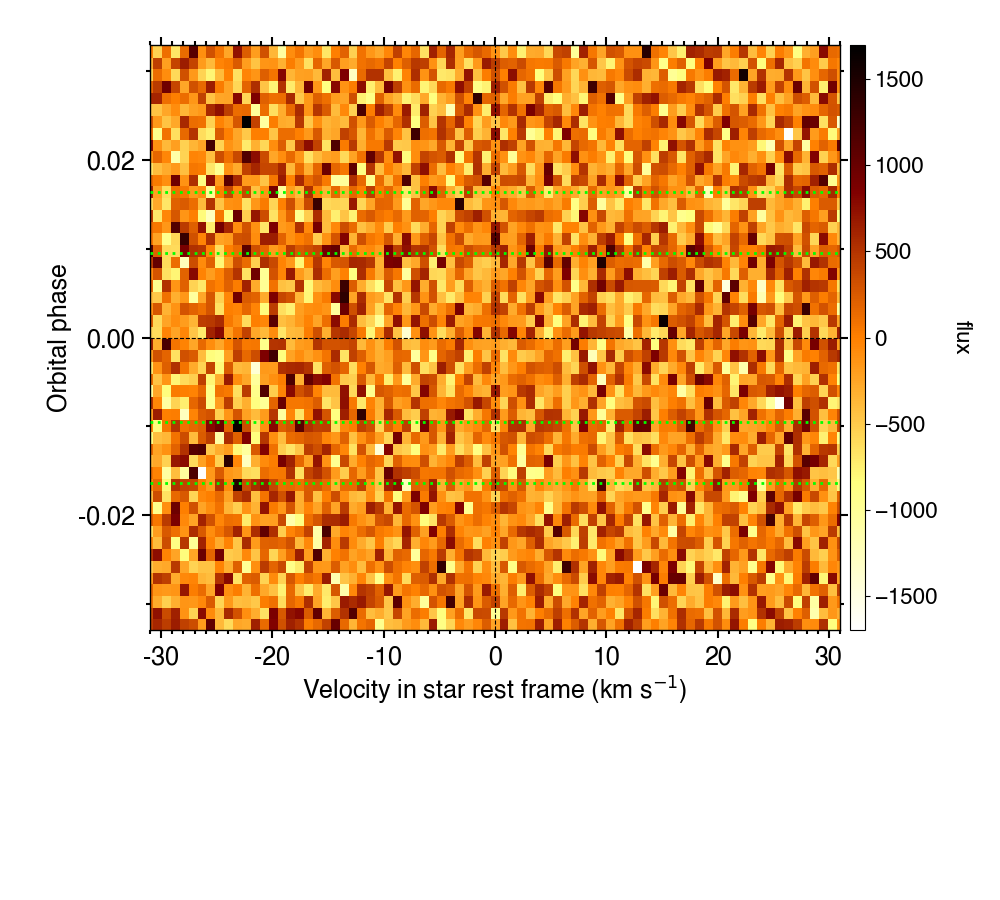

In [20]:
Image(filename = input_nbook['plot_path']+'Intr_data/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'_Map/Res/'+input_nbook['par']['prof_type']+'/iord0_glob_mod_rec_res.png')

# Results comparison for the example mock dataset

If you applied the notebook with default settings, you should have retrieved best-fit values from the RM Revolutions analysis that match the properties used to generate the default mock dataset:
- a projected stellar surface velocity `vsini` = 3 km/s
- a sky-projected spin-orbit angle `lambda` = 35 degrees
- an intrinsic stellar line `contrast` = 0.7
- an intrinsic stellar line `FWHM` = 2.5 km/s 